In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import math 
import numpy as np

# 生成数据
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
# i次方&除以i+1的阶乘
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
## x1 and x2 must be broadcastable to the same shape; element-wise
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)
#？ 为什么所有维度都加上了噪声

# NumPyndarray转换成tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]
## list快捷写法


# 对模型进行训练和测试
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    loss = nn.MSELoss(reduction='none')
    trainer = torch.optim.SGD(net.parameters(), lr=0.001)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())
    

weight: [[ 5.0059843  1.2242705 -3.4163194  5.5421524]]


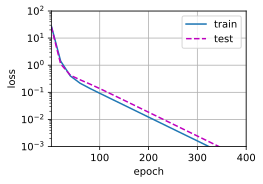

In [2]:
# 采用三阶多项式来拟合
# 使用三阶多项式函数，它与数据生成函数的阶数相同
train(poly_features[:n_train, :4], poly_features[n_train:, :4], 
     labels[:n_train], labels[n_train:])

weight: [[3.3186588 4.0545344]]


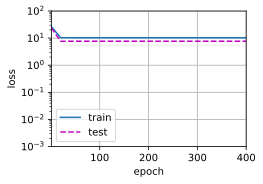

In [3]:
# 采用二阶多项式
# 模拟欠拟合
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9625325e+00  1.2935721e+00 -3.1923647e+00  5.1192737e+00
  -5.5823773e-01  1.0542940e+00 -1.8412763e-01  1.5626067e-01
   2.5055874e-02 -9.4580032e-02  1.0553456e-02 -1.6750021e-01
  -4.2940713e-02 -3.5249494e-02 -4.0339236e-03  9.2508942e-03
  -4.5851264e-02 -1.5357935e-01  1.3847637e-01 -6.2034428e-03]]


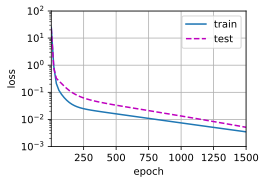

In [4]:
# 采用所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)